# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Prevent incompatible gpu

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 5713 files belonging to 3 classes.
Found 716 files belonging to 3 classes.
Found 713 files belonging to 3 classes.


,broccoli,cauliflower,unknown,splits total
test,246,235,232,713
train,1975,1880,1858,5713
validate,248,236,232,716
img total,2469,2351,2322,7142


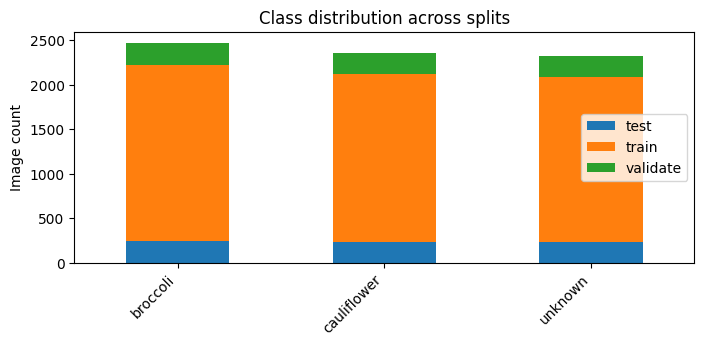

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

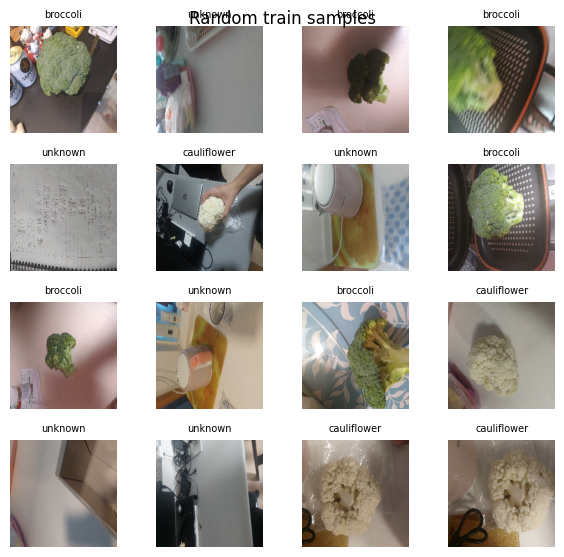

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

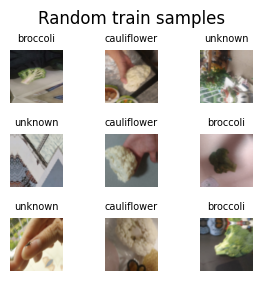

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model_weights.hdf5')
tf.keras.models.save_model(model,'model.hdf5')

Epoch 1/50
23/23 [==============================] - 696s 17s/step - loss: 1.0828 - accuracy: 0.3987 - val_loss: 0.9666 - val_accuracy: 0.5656
Epoch 2/50
23/23 [==============================] - 442s 6s/step - loss: 0.9480 - accuracy: 0.5269 - val_loss: 0.8101 - val_accuracy: 0.6327
Epoch 3/50
23/23 [==============================] - 116s 3s/step - loss: 0.8315 - accuracy: 0.6156 - val_loss: 0.6637 - val_accuracy: 0.6927
Epoch 4/50
23/23 [==============================] - 118s 3s/step - loss: 0.6567 - accuracy: 0.7196 - val_loss: 0.5072 - val_accuracy: 0.7863
Epoch 5/50
23/23 [==============================] - 119s 3s/step - loss: 0.4261 - accuracy: 0.8306 - val_loss: 0.2036 - val_accuracy: 0.9218
Epoch 6/50
23/23 [==============================] - 122s 3s/step - loss: 0.3601 - accuracy: 0.8635 - val_loss: 0.5570 - val_accuracy: 0.7612
Epoch 7/50
23/23 [==============================] - 119s 3s/step - loss: 0.4512 - accuracy: 0.8225 - val_loss: 0.4345 - val_accuracy: 0.7849
Epoch 8/50
2

# Model Evalutation

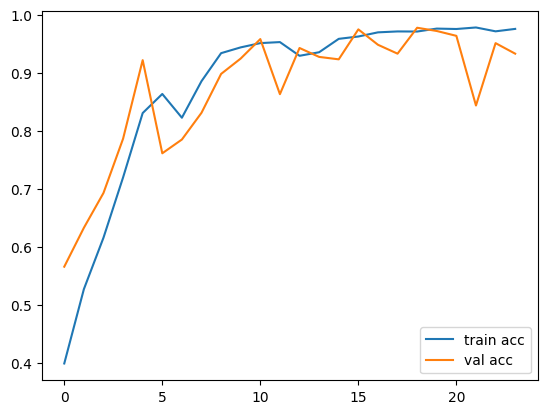

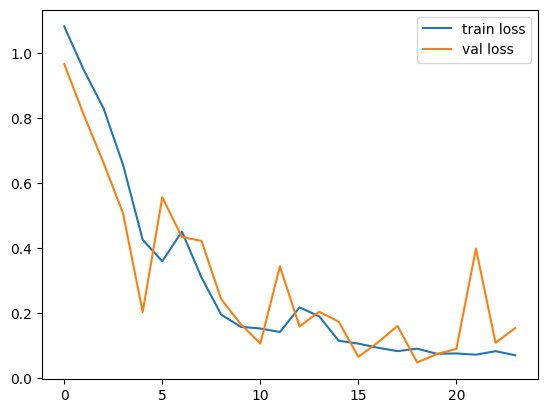

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()